In [2]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [3]:
def read_data():
    df_credits = pd.read_csv('../data/User Credits Student Access.csv', encoding='utf-8')
    df_atlas = pd.read_csv('../data/Atlas Cechu Student Access.csv', encoding='utf-8')
    df_payments = pd.read_csv('../data/Payments Student Access.csv', encoding='utf-8')
    return df_credits, df_atlas, df_payments

def data_cleaning(df_credits, df_payments):
    df_credits_cleaned = df_credits[df_credits['credits']>0]
    df_payments_cleaned = df_payments[(df_payments['id'].notnull())&(df_payments['credits']>500)]
    return df_credits_cleaned, df_payments_cleaned

In [21]:
df_credits, _, df_payments = read_data()
_, df_payments_cleaned = data_cleaning(df_credits, df_payments)

In [40]:
df_payments_cleaned['created_at'] = pd.to_datetime(df_payments_cleaned['created_at'], errors='coerce').dt.to_period('M').astype(str)

df_payments_cleaned = df_payments_cleaned[df_payments_cleaned['created_at']!='2025-04']

df_model = pd.DataFrame(df_payments_cleaned.groupby('created_at')['credits'].sum()).reset_index()
df_model = df_model.rename(columns={'credits':'credits_withdraw'})

/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_49972/1563143178.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payments_cleaned['created_at'] = pd.to_datetime(df_payments_cleaned['created_at'], errors='coerce').dt.to_period('M').astype(str)


In [43]:
X = df_model['created_at']
y = df_model['credits_withdraw']

forecast_len = 6
X_train = X.iloc[:-forecast_len]
X_test = X.iloc[-forecast_len:]
y_train = y.iloc[:-forecast_len]
y_test = y.iloc[-forecast_len:]

model = ARIMA(y_train, order=(5,1,0))


model_fit = model.fit()
forecast = model_fit.forecast(steps=forecast_len)

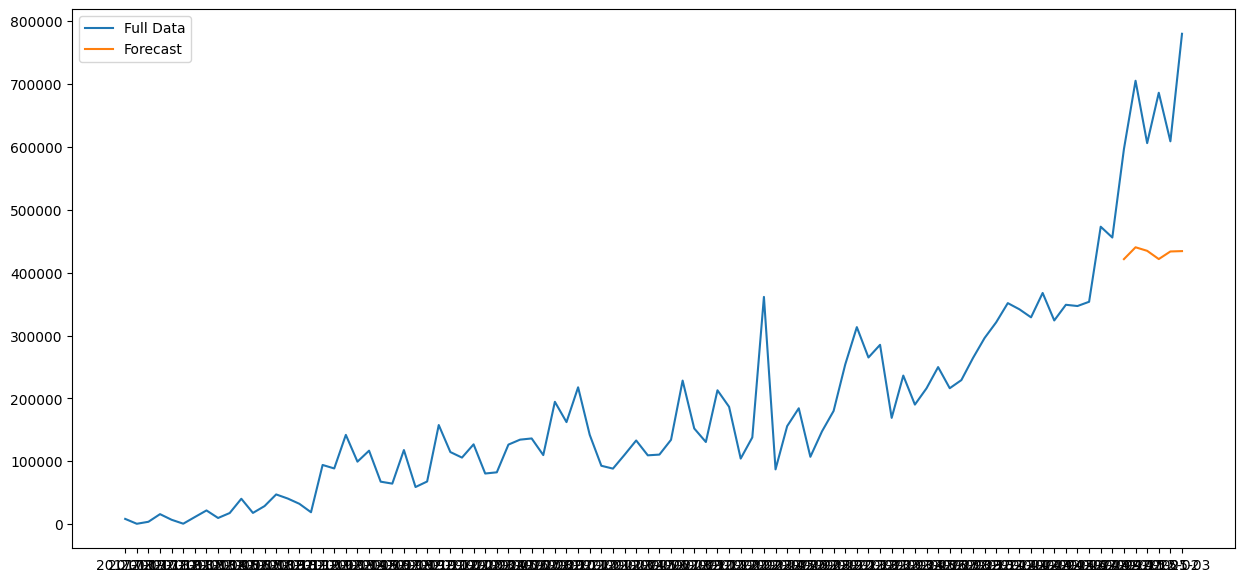

In [47]:
plt.figure(figsize=(15, 7))
plt.plot(X, y, label='Full Data')
plt.plot(X_test, forecast.values, label='Forecast')
plt.legend()
plt.show()

In [26]:
df_model

,created_at,credits_withdraw
0,2017-08,8316.0
1,2017-09,549.0
2,2017-10,3730.0
3,2017-11,15867.0
4,2017-12,6903.0
...,...,...
88,2024-12,606000.0
89,2025-01,686135.0
90,2025-02,608861.0
91,2025-03,779949.0


In [56]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [58]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [37]:
df_model_ai = df_model.copy()
df_model_ai['created_at'] = pd.to_datetime(df_model_ai['created_at'])
df_model_ai.set_index('created_at', inplace=True)
data = df_model_ai['credits_withdraw'].values.reshape(-1, 1)

In [ ]:
# --- Normalize the data ---
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# --- Create sequences ---
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(data_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# --- Train-test split ---
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === LSTM Model ===
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.1),
    LSTM(32),
    Dropout(0.1),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

# === GRU Model ===
gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.2),
    GRU(32, return_sequences=True),
    Dropout(0.2),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    verbose=0
)

# --- Make predictions ---
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)

# --- Inverse scale ---
y_test_inv = scaler.inverse_transform(y_test)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual', linewidth=2)
plt.plot(y_pred_lstm_inv, label='LSTM Forecast')
plt.plot(y_pred_gru_inv, label='GRU Forecast')
plt.title('LSTM vs GRU Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Credits Withdraw')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
